# TODO:
* Check seed worker reference  because the parameter is currently not being used
* Incorporate learning scheduler 
* Incorporate better optimizer

In [1]:
import pandas as pd
import numpy as np
import torch
from pytorch_pretrained_bert import BertForSequenceClassification

from transformers import BertTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, random_split, RandomSampler

import matplotlib.pyplot as plt

import random

import time
import os

/Users/Gerardo/.virtualenvs/neuro_match/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 31

## Set the random seeds for Python and Torch
random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)

def seed_worker(worker_id): #function to initalize the seeds for the workers of DataLoader
    worker_seed = torch.initial_seed() %2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g_seed = torch.Generator()
g_seed.manual_seed(seed)

In [3]:
my_tokenizer = BertTokenizer.from_pretrained("bert-base-cased") #load pre-trained tokenizer

In [4]:
#Tokenize, pad, and tensorize the features
#the apply returns a series of dictionaries, so we turn into a list -> DataFrame so that we can 
#store everything together efficiently
def process_data_frame(input_df):
    """Process DataFrame to format required for Pytorch

    Args:
        input_df (pandas.DataFrame): DataFrame read from csv

    Returns:
        pd.DataFrame: DataFrame with tensor data
    """
    tensor_df = pd.DataFrame(list(input_df['text'].apply(lambda x: my_tokenizer(x,truncation = True, 
                                                           max_length = 512, 
                                                           add_special_tokens= True,
                                                           padding = 'max_length',
                                                           return_tensors = 'pt',
                                                           return_attention_mask = True))))
    tensor_df['label'] = torch.tensor(input_df['label'].values) #tensorize labels
    
    return tensor_df

#Turn the pandas dataframes into lists then tensors as shown in https://mccormickml.com/2019/07/22/BERT-fine-tuning/#31-bert-tokenizer
def custom_train_test_split(df,features = 'input_ids',target = 'label',attention = 'attention_mask' ,test_size = 0.2,val_size = 0.2):
    """Return two dataset objects of training and testing samples respectively

    Args:
        df (pandas.DataFrame): DataFrame containing all the relevant columns 
        features (str, optional): DataFrame column correspondign to the feature components. Defaults to 'input_ids'.
        target (str, optional): DataFrame column corresponding to the label/target . Defaults to 'label'.
        attention (str, optional): DataFrame column corresponding to the attention tokens. Defaults to 'attention_mask'.
        test_size (float, optional): Percent size assigned to testing. Defaults to 0.2.
        val_size (float, optional): Percent size assigne to validation. Defaults to 0.2.

    Returns:
        tuple: Training,testing, and validation datasets objects respectively
    """
    
    
    #Turn DataFrame into tensor objects and then into a dataset
    X_label = torch.cat(df[features].to_list(),dim = 0) #tokenized data
    X_attention = torch.cat(df[attention].to_list(),dim = 0) #whether its a word or padding
    y = torch.tensor(df[target].to_list())
    dataset = TensorDataset(X_label,X_attention,y)
    
    #Split into training and testing datasets
    num_samps = df.shape[0]
    num_test = int(num_samps*test_size)
    num_train = num_samps - num_test
    
    train_data, test_data = random_split(dataset,[num_train,num_test])
    
    #Now split and get a validation dataset as well
    num_samps = len(train_data)
    num_val = int(num_samps*val_size)
    num_train = num_samps - num_val
    
    train_data, val_data = random_split(train_data, [num_train, num_val])
    
    return train_data,test_data,val_data

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: Running on cpu ")
  else:
    print("GPU is enabled in this notebook.")

  return device

def freeze_all_but_classifier(model,freeze_status = True):
  """Freeze all the layers but the classification layer

  Args:
      model (BERT model): model to freeze layers on 
      freeze_status (bool, optional): Sets the requires_grad of all the previous layers to this value. Defaults to True.

  Returns:
      BERT model: the model that we are using, with layers frozen or not depending on do.
  """
  for name,tensors in model.named_parameters():
   if 'classifier' not in name:
      tensors.requires_grad = freeze_status
    
  return model

In [5]:
if not os.path.isfile('data/modeling_data.zip'): #if the data has not been processed into tensors, read from csv and process
    df = pd.read_csv('data/cleandata.zip') #load dataset
    df.dropna(inplace = True) #drop nans (4 samples)
    
    df = process_data_frame(df)
    df.to_pickle('data/modeling_data.zip')
else: #read from pickle object if it has already been processed
    df = pd.read_pickle('data/modeling_data.zip')

In [6]:
train_dataset, test_dataset, validation_dataset = custom_train_test_split(df)

In [7]:
#Define Hyperparameters
max_batches = 3 #If we just want to do a subset of batches
batch_size = 1
lr = 0.001
eps = 1e-8
epochs = 10 #The BERT authors recommend between 2 and 4. Adjust to 2 if overfitting.
freeze_layers = True #Set to True if we want to freeze all the layers but the classification layer
batch_n_report = 1 #Report every this amount of batches

In [8]:
test_loader = DataLoader(test_dataset,batch_size = batch_size , shuffle = False, num_workers = 0, worker_init_fn = seed_worker, generator = g_seed)
train_loader = DataLoader(train_dataset,batch_size = batch_size , drop_last = True, shuffle = True, worker_init_fn = seed_worker, generator = g_seed)
validation_loader = DataLoader(validation_dataset,batch_size = batch_size , shuffle = False, num_workers = 0, worker_init_fn = seed_worker, generator = g_seed)

In [9]:
this_model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels = 2)
this_model = freeze_all_but_classifier(this_model,freeze_status = freeze_layers)
this_optim = my_optim = AdamW(this_model.parameters(),lr=lr,eps = eps)

# Total number of training steps is [number of batches] x [number of epochs]. NOT the total number of samples
if max_batches == np.nan:
    total_steps = len(train_loader) * epochs 
else:
    total_steps = max_batches * epochs 
scheduler = get_linear_schedule_with_warmup(my_optim, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [12]:
def train_loop(model,
               optimizer,
               train_dataset,
               test_dataset,
               val_dataset = [],
               epochs = 4,
               device = 'cpu',
               report_every_n_batches = 10,
               max_batch = np.nan): 
    """Training loop for the model that outputs a loss

    Args:
        model (torch.model): Output of model has to be a loss, not labels
        optimizer (torch.optimizer): Optimizer with the model parameters already fed in
        train_dataset (torch.DataLoader) : Training dataset that has 3 outputs (features, attention, labels)
        test_dataset (torch.DataLoader) : Test dataset that has 3 outputs (features, attention, labels)
        val_dataset (torch.DataLoader,optional): Validation dataset that has 3 outputs (features, attention, labels). Defaults to [].
        epochs (int, optional): Number of epochs to reiterate through batches. Defaults to 4.
        device (str, optional): Device to load the data unto. Defaults to 'cpu'.
        report_every_n_batches (int, optional): Number of epochs to update the loss everytime. Defaults to 10.
        max_batch(int, optional): Max number of batches to asses. Defaults to np.nan.

    Returns:
        tuple: Training loss, Validation Loss lists
    """
  
    ts = time.time()
    append = ''
    if max_batch is not np.nan:
        append  = f'.\nOnly doing {max_batch} batches.'
    print(f'Begin model Training. \nTotal epochs: {epochs}.\nTotal training batches: {len(train_dataset)}.\
          \nTotal validation batches: {len(val_dataset)}.\nTotal training batches: {len(test_dataset)}' + append + '\n')
  
    model.to(device)
    all_train_loss, all_eval_loss, all_accuracy = [],[],[]
    for ep in range(epochs): #iterate the desired epochs
        tb = time.time()
        
        print(f'------------------- Epoch {ep} ------------------- ')
        train_loss,eval_loss,accuracy = 0 ,0 ,0
        
        #Perform training of the model
        model.train()
        for iter,batch in enumerate(train_dataset): #iterate through all batches
            t0 = time.time()    
            if iter > max_batch: #in case we want to do a batch_subset
                break
            
            feature = batch[0].to(device) #extract relevant values and move to device
            attention = batch[1].to(device)
            label = batch[2].to(device)
            
            optimizer.zero_grad() #zero the gradients
            loss = model(feature,token_type_ids = None, attention_mask = attention, labels = label)
            
            train_loss += loss.detach().numpy() #calculate epoch loss and detach
            
            loss.backward() #estimate the gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) #clip gradients to avoid "exploding gradients"
            optimizer.step() #adjust parameters
            scheduler.step() #adjust the scheduler
            
            if iter % report_every_n_batches == 0 and not iter ==0: #update output every 10 batches
                elapsed_t = round(time.time() - t0,2)
                print(f'Batch {iter} done in {elapsed_t} seconds. Total training loss: {np.round(float(train_loss),4)}')
        
        #Perform validation of the model
        model.eval()
        for iter,batch in enumerate(val_dataset):
            if iter > max_batch: #in case we want to do a batch_subset
                break
            
            feature = batch[0].to(device) #extract relevant values and move to device
            attention = batch[1].to(device)
            label = batch[2].to(device)
            
            with torch.no_grad(): #we don't want to estimate gradients when validating
                loss = model(feature,token_type_ids = None, attention_mask = attention, labels = label)
            
            eval_loss += loss.detach().numpy() #detach from tensors and turn into numpy arrays to plot and calculate
            
        for iter,batch in enumerate(test_dataset):
            if iter > max_batch: #in case we want to do a batch subset
                break
            feature = batch[0].to(device)
            attention = batch[1].to(device)
            labels = batch[2]
            
            with torch.no_grad(): #we don't want to estimate gradients when validating
                logits = model(feature,token_type_ids = None, attention_mask = attention)
                
            logits.detach().to('cpu').numpy()
            preds = np.argmax(logits.detach().numpy(),axis = 1) #find the maximum probits
            accuracy  += np.sum(preds == labels) / len(labels) #find percent of accurate predictions
            

                   
        all_train_loss.append(train_loss)
        all_eval_loss.append(eval_loss) #append losses to visualize across epochs
        all_accuracy.append(accuracy)
        
        t_ep = round(time.time() - tb,2)
        print(f'\nEpoch {ep} done in {t_ep} seconds. Total training loss: {np.round(float(train_loss),4)}, Total validation loss: {np.round(float(eval_loss),4)}')
        print(f'Averaged across batches: Training loss: {np.round(train_loss / iter,4)}, Validation loss: {np.round(eval_loss /iter,4)}')
        print(f'Accuracy on Testing Dataset for this epoch: {np.round(accuracy,2)}%\n')
      
    print(f'-------------------  DONE TRAINING -------------------------------------- \n total time: {round(time.time() - ts,2)} seconds')
    return all_train_loss,all_eval_loss,all_accuracy
    

Begin model Training. 
Total epochs: 10.
Total training batches: 190247.          
Total validation batches: 47561.
Total training batches: 59452.
Only doing 3 batches.

------------------- Epoch 0 ------------------- 
Batch 1 done in 5.88 seconds. Total training loss: 3.0588
Batch 2 done in 4.16 seconds. Total training loss: 6.0863
Batch 3 done in 3.18 seconds. Total training loss: 9.556

Epoch 0 done in 21.08 seconds. Total training loss: 9.556, Total validation loss: 10.1351
Averaged across batches: Training loss: 2.389, Validation loss: 2.5338
Accuracy on Testing Dataset for this epoch: 0.0%

------------------- Epoch 1 ------------------- 
Batch 1 done in 3.06 seconds. Total training loss: 6.7824
Batch 2 done in 2.84 seconds. Total training loss: 10.5775
Batch 3 done in 3.52 seconds. Total training loss: 10.617

Epoch 1 done in 17.19 seconds. Total training loss: 10.617, Total validation loss: 10.1351
Averaged across batches: Training loss: 2.6543, Validation loss: 2.5338
Accuracy

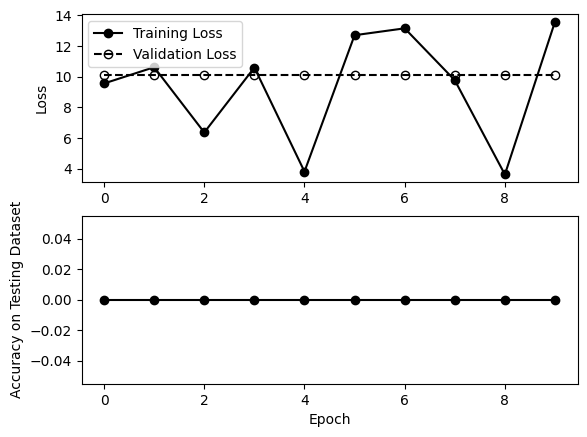

In [13]:
train_loss,eval_loss,accuracies = train_loop(this_model,
                                             this_optim,
                                             train_loader,
                                             test_loader,
                                             val_dataset = validation_loader,
                                             epochs = epochs,
                                             report_every_n_batches= batch_n_report,
                                             device = set_device(),
                                             max_batch = max_batches)


plt.subplot(211)
plt.plot(range(epochs),train_loss,color = 'black',linestyle = 'solid',marker = 'o',label = 'Training Loss')
plt.plot(range(epochs),eval_loss,color = 'black',linestyle = 'dashed',marker = 'o',fillstyle = 'none',label = 'Validation Loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(212)
plt.plot(range(epochs),accuracies,color = 'black',linestyle = 'solid',marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy on Testing Dataset');